<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_MNIST_noiseAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [2]:
#import dataset
dataFull = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# normalize the data to a range of [0 1]
dataFull[:, 1:] = dataFull[:, 1:] / np.max(dataFull)

In [8]:
# now for the function
def makeTheDataset(N, doubleTheData=False):

    # extract labels (number IDs) and remove from data
    labels = dataFull[:N, 0]
    data = dataFull[:N, 1:]


    # make a noisy copy of All the data
    if doubleTheData:
        dataN = data + np.random.random_sample(data.shape) / 2
        dataN[:, 1:] = dataN[:, 1:] / np.max(dataN)
        data = np.concatenate((data, dataN), axis=0)
        labels = np.concatenate((labels, labels), axis=0)


    # convert to tensor
    dataT = torch.tensor(data).float()
    labelsT = torch.tensor(labels).long()

    # use scikitlearn to split the data
    train_data, devset_data, train_labels, devset_labels = train_test_split(dataT, labelsT, train_size=.9)

    # # make an exact copy of the TRAIN data
    # if doubleTheData:
    #     train_dataN = train_data + torch.rand_like(train_data) / 2
    #     train_data = torch.cat((train_data, train_dataN), axis=0)
    #     train_labels = torch.cat((train_labels, train_labels), axis=0)

    # convert into pyTorch Datasets
    train_data = TensorDataset(train_data, train_labels)
    devset_data = TensorDataset(devset_data, devset_labels)

    # translate into dataloader
    batchsize = 20
    train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
    devset_loader = DataLoader(devset_data, batch_size=devset_data.tensors[0].shape[0])

    # NEW! Create a test set (don't need a dataloader)
    testdata = torch.tensor(dataFull[N:, 1:]).float()
    testlabels = torch.tensor(dataFull[N:, 0]).float()

    return train_loader, devset_loader, (testdata, testlabels)


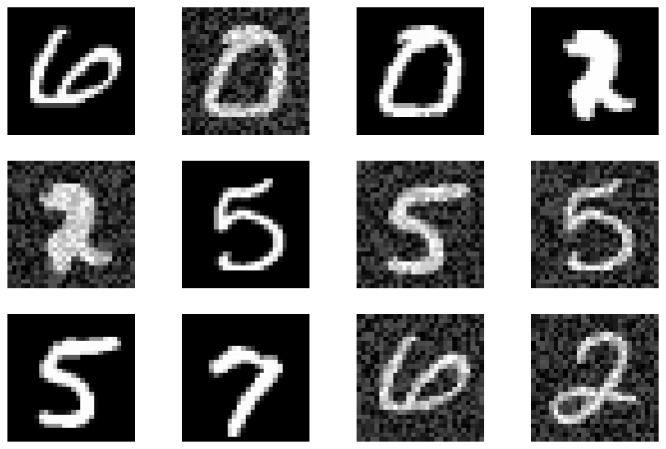

In [9]:
# visualize the images

# get some sample data
train_loader, devset_loader, testdataset = makeTheDataset(12, True)

# pop out the data matrices
img = train_loader.dataset.tensors[0].detach()

# show the numbers
fig, ax = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(ax.flatten()):
    ax.imshow(np.reshape(img[i, :], (28, 28)), cmap='gray')
    ax.axis('off')
plt.show()

## Create the DL model

In [10]:
# create a class for the model

def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 64)

            ## hidden layer
            self.fc1 = nn.Linear(64, 32)
            self.fc2 = nn.Linear(32, 32)

            ## output layer
            self.output = nn.Linear(32, 10)
        
        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
            return self.output(x)

        
    net = mnistNet()

    # loss function 
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfun, optimizer

In [11]:
def function2trainTheModel():

    # number of epochs
    numepochs = 50

    # create a new model
    net, lossfun, optimizer = createTheMNISTNet()

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    devsetAcc = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y 
            matchesNumeric = matches.float()
            accuracyPct = 100*torch.mean(matchesNumeric) 
            batchAcc.append(accuracyPct) 

        # end of batch loop

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        X, y = next(iter(devset_loader))
        with torch.no_grad():
            yHat = net(X)

        # compare the following really lon gline of code the training accuracy lines
        devsetAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs
    
    # function output
    return trainAcc, devsetAcc, losses, net

## Run the model and show the results!

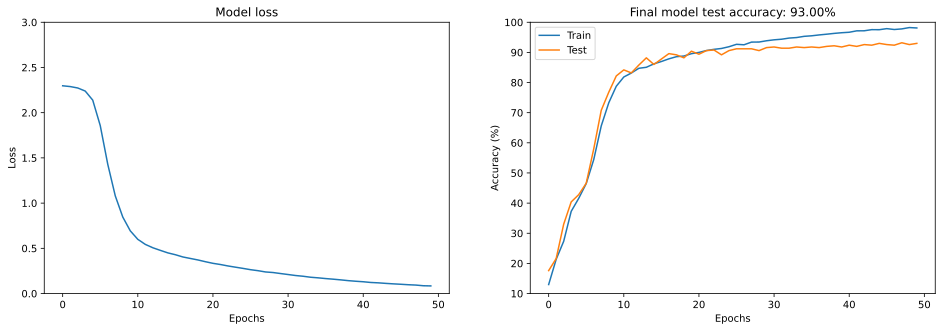

In [13]:
# generate a dataset
train_loader, devset_loader, testset = makeTheDataset(5000)

# test it
trainAcc, devsetAcc, losses, net = function2trainTheModel()

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0, 3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(devsetAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {devsetAcc[-1]:.2f}%')
ax[1].set_ylim([10, 100])
ax[1].legend()

plt.show()

## Run an experiment showing better performance with increased N

In [14]:
# takes ~3 minutes

# list of data sample sizes
samplesizes = np.arange(500, 4001, 500)

# initialize results matrix
resultsSingle = np.zeros((len(samplesizes), 3))
resultsDouble = np.zeros((len(samplesizes), 3))


for idx, ssize in enumerate(samplesizes):

    ## without doubling the data

    # generate a dataset and train the model
    train_loader, devset_loader, testdataset = makeTheDataset(ssize, False)
    trainAcc, devsetAcc, losses, net = function2trainTheModel()

    # grab the results
    resultsSingle[idx, 0] = np.mean(trainAcc[-5:])
    resultsSingle[idx, 1] = np.mean(devsetAcc[-5:])
    resultsSingle[idx, 2] = torch.mean(losses[-5:]).item()


    ### with doubling the data

    # generate a dataset and train the model
    train_loader, test_loader, testdataset = makeTheDataset(ssize, True)
    trainAcc, devsetAcc, losses, net = function2trainTheModel()

    # grab the results
    resultsDouble[idx, 0] = np.mean(trainAcc[-5:])
    resultsDouble[idx, 1] = np.mean(devsetAcc[-5:])
    resultsDouble[idx, 2] = torch.mean(losses[-5:]).item()




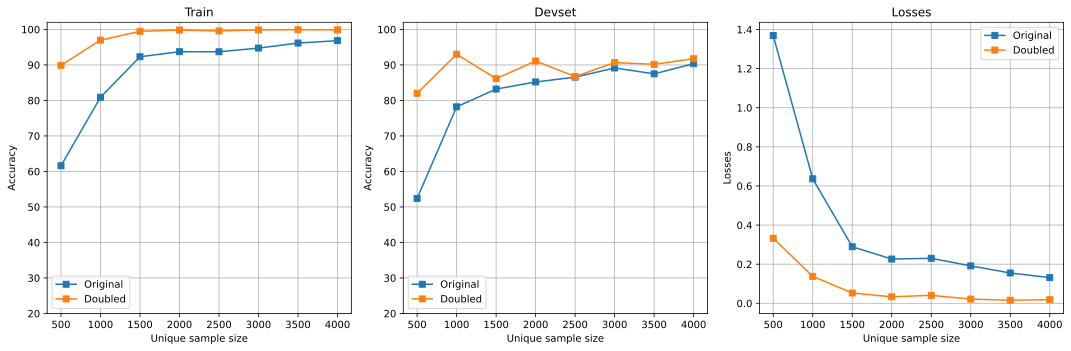

In [ ]:
# Let's see what the results look like!
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# axis and title labels
titles = ['Train', 'Devset', 'Losses']
yaxlabels = ['Accuracy', 'Accuracy', 'Losses']

# common features
for i in range(3):

    # plot the lines
    ax[i].plot(samplesizes, resultsSingle[:, i], 's-', label='Original')
    ax[i].plot(samplesizes, resultsDouble[:, i], 's-', label='Augmented')

    # make it look nicer
    ax[i].set_ylabel(yaxlabels[i])
    ax[i].set_title(titles[i])
    ax[i].legend()
    ax[i].set_xlabel('Unique sample size')
    ax[i].grid('on')

    if i < 2:
        ax[i].set_ylim([20, 102])

plt.tight_layout()
plt.show()

## Now for test accuracy

In [15]:
# we need to re run the models for N = 500
samplesize = 500

train_loader, devset_loader, testdataset = makeTheDataset(samplesize, False)
trainAccO, devsetAccO, lossesO, netO = function2trainTheModel() # o = original

train_loader, devset_loader, testdataset = makeTheDataset(samplesize, True)
trainAccA, devsetAccA, lossesA, netA = function2trainTheModel() # A = augmented



In [20]:
# Now for the real test! On the test data!

# extract the test data
X, y = testdataset

# run the original model
yHat = netO(X)
testO = 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())

# and the augment model
yHat = netA(X)
testA = 100 * torch.mean((torch.argmax(yHat, axis=1) == y).float())

# print the results
print(f'Original Model (N = {samplesize}):\n Train: {trainAccO[-1]:.2f}%, devset: {devsetAccO[-1]:.2f}%, test: {testO:.2f}%')
print(f'Augmented Model (N = {samplesize}):\n Train: {trainAccA[-1]:.2f}%, devset: {devsetAccA[-1]:.2f}%, test: {testA:.2f}%')

Original Model (N = 500):
 Train: 42.95%, devset: 34.00%, test: 35.51%
Augmented Model (N = 500):
 Train: 91.44%, devset: 84.00%, test: 79.39%
